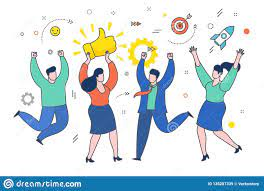

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# for Importing the Dataset
import pandas as pd
# for calculating Polarity and Subjectivity
from textblob import TextBlob
# load in all the modules we're going to need
import nltk
import collections
# for Wordscloud
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
# function for making ngrams
from nltk.util import ngrams
import time
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
plt.style.use(style="seaborn")
%matplotlib inline
import openpyxl
from pathlib import Path


In [ ]:
pip install openpyxl

#  هندسة الخصائص

### قراءه البيانات وتلخيص البيانات

In [ ]:
df_train=pd.read_csv('../input/feedback-prize-2021/train.csv')

# عرض البايانات

In [ ]:
df_train.head(10)

In [ ]:
df_train.shape

# عرض المعلومات الخاصه بالبيانات

In [ ]:
df_train.info()

# عرض اما اذا كانت البيانات تحتوى على اى فقد من الخلايا 

In [ ]:
# عرض اما اذا كانت البيانات تحتوى على اى فقد
df_train.isnull().sum()

In [ ]:
# عرض او وصف البيانات عن طريق حساب ال متوسط والربع الاول والثانى 
df_train.describe()

In [ ]:
df_train.describe(include = 'object')

In [ ]:
# lets check the Value Counts for discourse_text 
df_train['discourse_text'].value_counts()

#  إيجاد الطول والقطبية والذاتية للنص

In [ ]:
# Lets calculate the length of the Reviews
df_train['length'] = df_train['discourse_text'].apply(len)

# استقطاب النص    

    إنه التعبير الذي يحدد الجانب العاطفي للرأي. في البيانات النصية ، يمكن تحديد نتيجة تحليل المشاعر لكل كيان في الجملة أو المستند أو الجملة. يمكن تحديد قطبية المشاعر على أنها إيجابية وسلبية ومحايدة.

In [ ]:
# Lets calculate the Polarity of the Reviews
def get_polarity(text):
    textblob = TextBlob(str(text.encode('utf-8')))
    pol = textblob.sentiment.polarity
    return pol

# lets apply the function
df_train['polarity'] = df_train['discourse_text'].apply(get_polarity)

` ذاتية النص

في اللغة الطبيعية ، تشير الذاتية إلى التعبير عن الآراء والتقييمات والمشاعر والتكهنات وبالتالي تتضمن المشاعر. يتم تصنيف النص الذاتي بشكل أكبر مع العاطفة أو القطبية.`

In [ ]:
# Lets calculate the Subjectvity of the Reviews
def get_subjectivity(text):
    textblob = TextBlob(str(text.encode('utf-8')))
    subj = textblob.sentiment.subjectivity
    return subj

# lets apply the Function
df_train['subjectivity'] = df_train['discourse_text'].apply(get_subjectivity)

In [ ]:
## lets summarize the Newly Created Features
df_train[['length','polarity','subjectivity']]

# إيجاد عدد الكلمات والشخصيات وعلامات الترقيم

In [ ]:
# calculating the Character Count in the Reviews
df_train['char_count'] = df_train['discourse_text'].apply(len)

In [ ]:
# calculating the Word Count
df_train['word_count'] = df_train['discourse_text'].apply(lambda x: len(x.split()))

In [ ]:
# Calculating the Word Density
df_train['word_density'] = df_train['char_count'] / (df_train['word_count']+1)

In [ ]:
# importing the List of Punctuations
import string
punctuation = string.punctuation

# Calculating the Punctuation Count
df_train['punctuation_count'] = df_train['discourse_text'].apply(lambda x: len("".join(_ for _ in x if _ in punctuation))) 

In [ ]:
## lets summarize the Newly Created Features
df_train[['char_count','word_count','word_density','punctuation_count']]

# تنظيف البيانات

In [ ]:
# lets make a function to remove Numbers from the reviews
import re
def drop_numbers(list_text):
    list_text_new = []
    for i in list_text:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ''.join(list_text_new)

df_train['discourse_text'] = df_train['discourse_text'].apply(drop_numbers)

In [ ]:
# lets visualize the Top 10 Reviews after Removal of Punctuations and Numbers
df_train['discourse_text'].head(10)

## رسم البيانات 

In [ ]:
## Visualizing Polarity and Subjectivity

plt.rcParams['figure.figsize'] = (10, 4)

plt.subplot(1, 2, 1)
sns.distplot(df_train['polarity'])

plt.subplot(1, 2, 2)
sns.distplot(df_train['subjectivity'])

plt.suptitle('Distribution of Polarity and Subjectivity')
plt.show()

In [ ]:
# lets check relation between Polarity and Subjectivity

sns.scatterplot(df_train['polarity'], df_train['subjectivity'],color='red')
plt.title('Polarity vs Subjectivity')
plt.show()

# تصور الكلمات الأكثر تكرارا

In [ ]:
## Visualizing the Most Frequent Words

from sklearn.feature_extraction.text import CountVectorizer


cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df_train.discourse_text)
sum_words = words.sum(axis=0)


words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

plt.style.use('fivethirtyeight')
color = plt.cm.ocean(np.linspace(0, 1, 20))
frequency.head(20).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
plt.title("Most Frequently Occuring Words - Top 20")
plt.show()

In [ ]:
## Visualizing the Least Frequent Words

from sklearn.feature_extraction.text import CountVectorizer


cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df_train.discourse_text)
sum_words = words.sum(axis=0)


words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

plt.style.use('fivethirtyeight')
color = plt.cm.ocean(np.linspace(0, 1, 20))
frequency.tail(20).plot(x='word', y='freq', kind='bar', figsize=(15, 6), color = color)
plt.title("Least Frequently Occuring Words - Top 20")
plt.show()

# تصور BiGrams

In [ ]:
# Visualizing the BiGrams

text = str(df_train['discourse_text'])
tokenized = text.split()

# and get a list of all the bi-grams
esBigrams = ngrams(tokenized, 2)

# get the frequency of each bigram in our corpus
esBigramFreq = collections.Counter(esBigrams)

# what are the ten most popular ngrams in this Spanish corpus?
esBigramFreq.most_common(10)

# تصور الأشكال الثلاثية

In [ ]:
# Visualizing the Trigrams

text = str(df_train['discourse_text'])
tokenized = text.split()

# and get a list of all the bi-grams
esTrigrams = ngrams(tokenized, 3)

# get the frequency of each bigram in our corpus
esTrigramFreq = collections.Counter(esTrigrams)

# what are the ten most popular ngrams in this Spanish corpus?
esTrigramFreq.most_common(10)

## دعنا نرسم سحابة الكلمات

In [ ]:
# lets plot the Wordscloud

cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df_train['discourse_text'])
sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

wordcloud = WordCloud(background_color = 'lightcyan', width = 2000, height = 2000).generate_from_frequencies(dict(words_freq))

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.imshow(wordcloud)
plt.title("Vocabulary from Reviews", fontsize = 20)
plt.show()

# حقيبة الكلمات

    نموذج حقيبة الكلمات هو تمثيل مبسط يستخدم في معالجة اللغة الطبيعية واسترجاع المعلومات (IR). في هذا النموذج ، يتم تمثيل النص (مثل جملة أو مستند) كحقيبة (مجموعة متعددة) من كلماته ، متجاهلاً القواعد النحوية وحتى ترتيب الكلمات مع الحفاظ على التعددية.

In [ ]:
## Cleaning the Data
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus = []

for i in range(0, 3150):
    review = re.sub('[^a-zA-Z]', ' ', df_train['discourse_text'][i])  ## Removing all Unecessary items
    review = review.lower()                                         ## Converting into Lower Case
    review = review.split()
    ps = PorterStemmer()                                            ## Stemming
    review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]  ## Removing Stopwords
    review = ' '.join(review)
    corpus.append(review)

# استخدام خورزميات التعليم العميق

In [ ]:
# creating bag of words
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features = 2500)

x = cv.fit_transform(corpus).toarray()
y = df_train.iloc[:, 4].values

print(x.shape)
print(y.shape)

In [ ]:
from collections import Counter

# Count unique words
def counter_word(Feed):
    count = Counter()
    for i in Feed.values:
        for word in i.split():
            count[word] += 1
    return count

In [ ]:
text = df_train['discourse_text']

counter = counter_word(text)
print(len(counter))

In [ ]:
train_size = int(df_train.shape[0] * 0.8)

train_sentences = df_train['discourse_text'][:train_size]
train_labels = df_train['discourse_text'][:train_size]

test_sentences = df_train['discourse_text'][train_size:]
test_labels = df_train['discourse_text'][train_size:]

In [ ]:
print(train_size)
print("*******************************")
print(train_sentences)
print("*******************************")
print(train_labels)

In [ ]:
pip install keras==2.3.1

In [ ]:
import keras
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(all)
tokenizer.fit_on_texts(train_sentences)

In [ ]:
word_index = tokenizer.word_index 
tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts(df_train['discourse_text'])
total_words = len(tokenizer.word_index) + 1

print("Total number of words: ", total_words)
print("Word: ID")
print("------------")
print("<oov>: ", tokenizer.word_index['<oov>'])

# حساب المتتاليات

In [ ]:
input_sequences = []
for line in df_train['discourse_text']:
    token_list = tokenizer.texts_to_sequences([line])[0]
    #here we can print the token_list but it is very long.
    #print(token_list[:1])
    
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# print(input_sequences)
print("Total input sequences: ", len(input_sequences))

In [ ]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences[1]

In [ ]:
# create features and label
xs, labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [ ]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150)))
model.add(Dense(total_words, activation='softmax'))
adam = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(xs, ys, epochs=50, verbose=1)
#print model.summary()
print(model)